In [1]:
#imports

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.neighbors import NearestNeighbors
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer


# Reading the data. Performing Exploratory Data Analysis

In [2]:
data = pd.read_csv('data_2.csv')
data = data.dropna(subset=['SquareFootageHouse'])
data['Location'] = data['Location'].replace('Suburbann', 'Suburban')
data['HeatingType'].replace({'Oil': 'Oil Heating', 'Electric': 'Electricity'}, inplace=True)
data['Bedrooms'] = data['Bedrooms'].astype(pd.Int64Dtype())
data['Bathrooms'] = data['Bathrooms'].astype(pd.Int64Dtype())


# Mapping of certain non numeric columns but can be represented as categorical. Useful for convertion for example location Urban, suburban into numerical data

In [3]:
mapping_location = {'Urban': 1, 'Suburban': 2, 'Rural': 3}
data['Location'] = data['Location'].map(mapping_location)

mapping_PoolQuality = {'Good': 2, 'Poor': 3, 'Excellent': 1}
data['PoolQuality'] = data['PoolQuality'].map(mapping_PoolQuality)


mapping_Kitchen = {'Good': 2, 'Poor': 3, 'Excellent': 1}
data['KitchensQuality'] = data['KitchensQuality'].map(mapping_Kitchen)

mapping_Bathrooms = {'Good': 2, 'Poor': 3, 'Excellent': 1}
data['BathroomsQuality'] = data['BathroomsQuality'].map(mapping_Bathrooms)

mapping_Bedrooms = {'Good': 2, 'Poor': 3, 'Excellent': 1}
data['BedroomsQuality'] = data['BedroomsQuality'].map(mapping_Bedrooms)


mapping_LivingRooms = {'Good': 2, 'Poor': 3, 'Excellent': 1}
data['LivingRoomsQuality'] = data['LivingRoomsQuality'].map(mapping_LivingRooms)

In [4]:
data['Location'] = data['Location'].astype(pd.Int64Dtype())

# Feature exploration

In [5]:
# Define the function to print value counts for a specified column
def print_column_info(column_name):
    if column_name in data.columns:
        value_counts = data[column_name].value_counts(dropna=False)
             
        print(value_counts)

     
#print_column_info('Location')
#print_column_info('PoolQuality')
#print_column_info('HasPhotovoltaics')
#print_column_info('Age')

# 0 means the house has no pool
data['PoolQuality'] = data['PoolQuality'].fillna(0)

print_column_info('HeatingType')


HeatingType
Oil Heating    414
Electricity    299
Gas            282
Name: count, dtype: int64


In [6]:
data.drop(columns=['HouseColor', 'PreviousOwnerName'], axis=1, inplace=True)
data.isna().sum()

Bedrooms               328
Bathrooms              165
SquareFootageHouse       0
Location               230
Age                    130
PoolQuality              0
HasPhotovoltaics       258
HeatingType              0
HasFiberglass            0
IsFurnished              0
DateSinceForSale         0
HasFireplace             0
KitchensQuality          0
BathroomsQuality         0
BedroomsQuality          0
LivingRoomsQuality       0
SquareFootageGarden      0
PreviousOwnerRating      0
HeatingCosts           452
WindowModelNames         0
Price                    0
dtype: int64

# Here we do some plotting of numeric columns, ignoring NaN for now

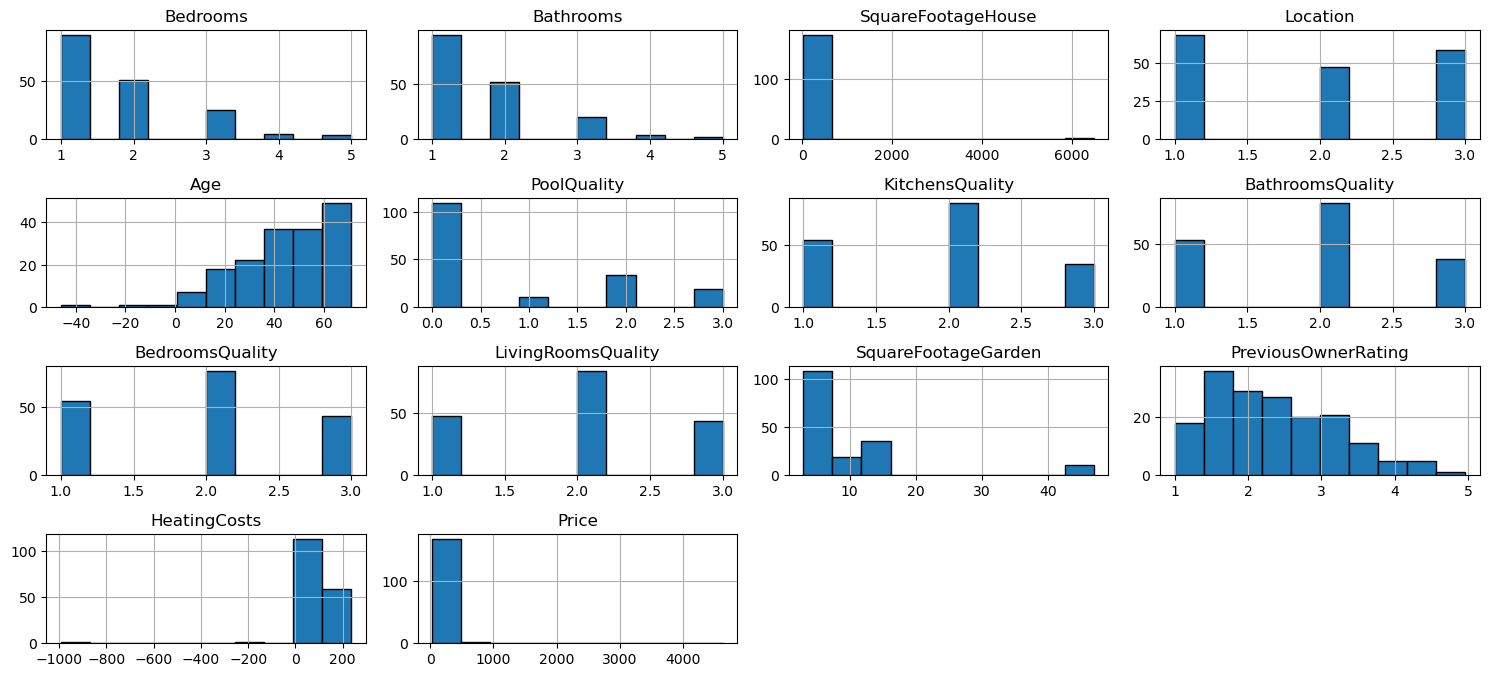

In [7]:
# Drop rows with NaN values to avoid issues in plotting
data_cleaned = data.dropna()

#number of columns for the layout
num_columns = 4 
num_rows = -(-len(data_cleaned.columns) // num_columns)  # Calculate rows needed

# histograms for each column
data_cleaned.hist(bins=10, figsize=(15, 10), layout=(num_rows, num_columns), edgecolor='black')

plt.tight_layout()
plt.show()

# Here we make a correlation matrix and then subsequently an heatmap to get an idea on how variables are correlated to eachother

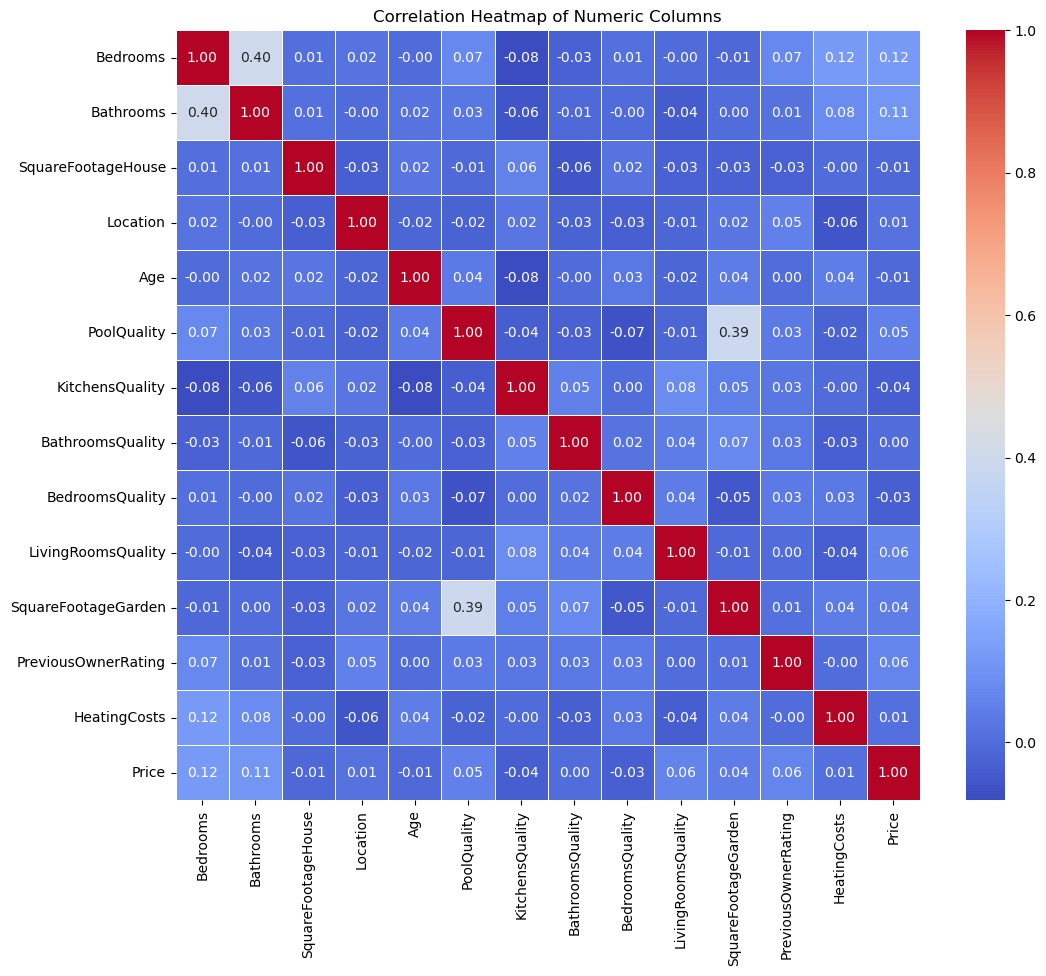

In [8]:

numeric_data = data.select_dtypes(include='number') # numeric columns
correlation_matrix = numeric_data.corr()

# heatmapping
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Numeric Columns')
plt.show()

### We can see for example that there is a strong correlation between PoolQuality and SquareFootageGarden  and between Bathrooms and Bedrooms

# Exploring "Price", our target variable. We can replace it whichever column name

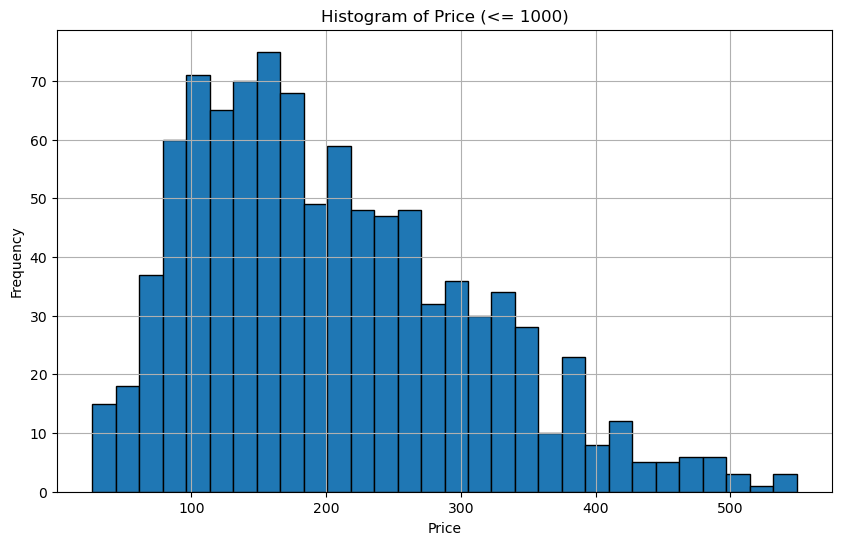

In [9]:
# Filter the "Price" column to include only values less than or equal to 1000
#sophisticated outlier removal technique !!! However, this is merely to test and visualize in a preliminary phase
filtered_price = data[data['Price'] <= 800]
dropped_price = data[data['Price'] > 800]

# Plot a histogram of the filtered "Price" column
plt.figure(figsize=(10, 6))
plt.hist(filtered_price['Price'].dropna(), bins=30, edgecolor='black')
plt.title('Histogram of Price (<= 1000)')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# dropped_price

## Let's try to visualize if there are any correlations between the age of a house and the Price

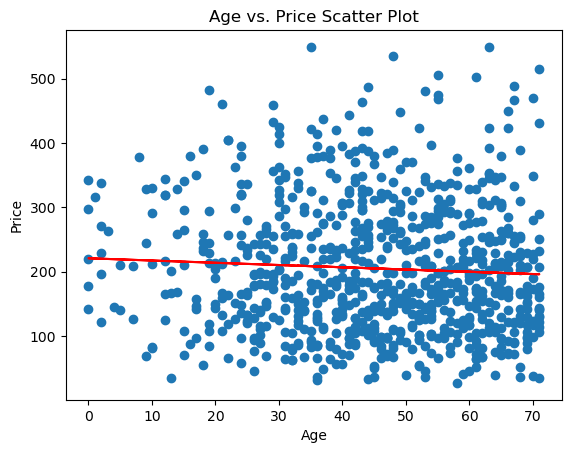

Correlation coefficient: -0.05698942876856539


In [10]:
# Apply filters simultaneously
filtered_data = data[(data['Age'] >= 0) & (data['Price'] <= 800)]

# Extract filtered age and price
filtered_age = filtered_data['Age']
filtered_price = filtered_data['Price']

# Fit a line (linear regression)
coefficients = np.polyfit(filtered_age, filtered_price, 1)
poly_function = np.poly1d(coefficients)

# Calculate correlation coefficient
correlation_matrix = np.corrcoef(filtered_age, filtered_price)
correlation = correlation_matrix[0, 1]

# Create a scatter plot
plt.scatter(filtered_age, filtered_price)

# Add the regression line
plt.plot(filtered_age, poly_function(filtered_age), color='red')

# Add labels and title
plt.xlabel('Age')
plt.ylabel('Price')
plt.title('Age vs. Price Scatter Plot')

# Show the plot
plt.show()

print("Correlation coefficient:", correlation)
#age has no effect on the hosue price

### There is a very, very negative correlation between those variabes. Meaning that as age increase price decreases very slightly. It is so small that it can be considered irrelevant or even non-existant

# Now let's start actually with the  pre-processing 

## First, we do some Dimensionality Reduction so we have less stuff to impute and care about.

To do this, we will apply PCA to reduce the number of variables to a more manageable number.

For this we should first normalize the data using the standard normalizations since that puts out distributions with a mean of 0 and a standard deviation of 1.

However, standardization only works on numerical data (obviously) so, we need to do one-hot-enconding and convert those categorial columns into numerical. the color of the house will be split into several columns like:

Green:  Yellow:   Red:
0        1         0
1        0         0
0        0         1
0        1         0
0        0         0




# Before however, we have to take care immediatly of the Nan/nulls since our strategies later dont handle them well

In [11]:

#1.1lets print the intial state of nan
print("Initial NaN counts per column in 'data':")
print(data.isna().sum())

#columns to use knn in
columns_to_impute = ['Bedrooms', 'Bathrooms', 'Age', 'HeatingCosts']

#subset of the main dataframw with the columns we want
dataToKnn = data[columns_to_impute]

#1.2 do the knn imputation
imputer = KNNImputer(n_neighbors=32)
df_imputed_subset = pd.DataFrame(imputer.fit_transform(dataToKnn), columns=columns_to_impute)

#verify how many nan are present in the dataset originally
print("\nNaN counts in 'df_imputed_subset' after imputation:")
print(df_imputed_subset.isna().sum())

# make sure the indices of the imputed subset match those of the original DataFrame. without this, the indices get mixed up and leads to incredible hard to debug errors!
df_imputed_subset.index = dataToKnn.index

#assign imputed values back into the original dataset
data[columns_to_impute] = df_imputed_subset

# did the reassignment worked ? if yes, then then 'Bedrooms', 'Bathrooms', 'Age', 'HeatingCosts' should have 0 
nan_counts = data.isna().sum()
print("\nNaN counts per column in 'data' after reassignment:")
print(nan_counts)


Initial NaN counts per column in 'data':
Bedrooms               328
Bathrooms              165
SquareFootageHouse       0
Location               230
Age                    130
PoolQuality              0
HasPhotovoltaics       258
HeatingType              0
HasFiberglass            0
IsFurnished              0
DateSinceForSale         0
HasFireplace             0
KitchensQuality          0
BathroomsQuality         0
BedroomsQuality          0
LivingRoomsQuality       0
SquareFootageGarden      0
PreviousOwnerRating      0
HeatingCosts           452
WindowModelNames         0
Price                    0
dtype: int64

NaN counts in 'df_imputed_subset' after imputation:
Bedrooms        0
Bathrooms       0
Age             0
HeatingCosts    0
dtype: int64

NaN counts per column in 'data' after reassignment:
Bedrooms                 0
Bathrooms                0
SquareFootageHouse       0
Location               230
Age                      0
PoolQuality              0
HasPhotovoltaics       258

# We cant apply knn to categorial values such as these, so instead, lets apply a decision tree algorithim to Location and HasPhotovoltaics . Decision tree looks at other patterns in the data and imputes the values based on that.

In [12]:
# Encode 'Location' and 'HasPhotovoltaics' columns
label_encoder_loc = LabelEncoder()
label_encoder_pv = LabelEncoder()
data['Location_encoded'] = label_encoder_loc.fit_transform(data['Location'].astype(str))
data['HasPhotovoltaics_encoded'] = label_encoder_pv.fit_transform(data['HasPhotovoltaics'].astype(str))

#rows with and without missing values
train_data_loc = data[data['Location'].notna()]
test_data_loc = data[data['Location'].isna()]

train_data_pv = data[data['HasPhotovoltaics'].notna()]
test_data_pv = data[data['HasPhotovoltaics'].isna()]

#identify categorical columns, excluding the target columns
categorical_columns = data.select_dtypes(include=['object']).columns.difference(['Location', 'HasPhotovoltaics'])

# one-hot encoding to categorical columns on the entire dataset. expands the dataset dramatically
one_hot_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
one_hot_encoded_full = one_hot_encoder.fit_transform(data[categorical_columns])

#dataFrame from the one-hot encoded array
one_hot_encoded_full_df = pd.DataFrame(one_hot_encoded_full, index=data.index, columns=one_hot_encoder.get_feature_names_out(categorical_columns))

# now we have to split the dataframe into train/test sets. two for each variable naturally
one_hot_encoded_train_loc_df = one_hot_encoded_full_df.loc[train_data_loc.index]
one_hot_encoded_test_loc_df = one_hot_encoded_full_df.loc[test_data_loc.index]

one_hot_encoded_train_pv_df = one_hot_encoded_full_df.loc[train_data_pv.index]
one_hot_encoded_test_pv_df = one_hot_encoded_full_df.loc[test_data_pv.index]

#join one-hot-econded with the rest of the features
train_data_loc = train_data_loc.drop(columns=categorical_columns).join(one_hot_encoded_train_loc_df)
test_data_loc = test_data_loc.drop(columns=categorical_columns).join(one_hot_encoded_test_loc_df)

train_data_pv = train_data_pv.drop(columns=categorical_columns).join(one_hot_encoded_train_pv_df)
test_data_pv = test_data_pv.drop(columns=categorical_columns).join(one_hot_encoded_test_pv_df)

# finally we have the features for training the decision tree (excluding the target columns)
features_loc = train_data_loc.columns.drop(['Location', 'Location_encoded'])
features_pv = train_data_pv.columns.drop(['HasPhotovoltaics', 'HasPhotovoltaics_encoded'])

#decision tree classifier for 'Location'
classifier_loc = DecisionTreeClassifier()
classifier_loc.fit(train_data_loc[features_loc], train_data_loc['Location_encoded'])

#decision tree classifier for 'HasPhotovoltaics'
classifier_pv = DecisionTreeClassifier()
classifier_pv.fit(train_data_pv[features_pv], train_data_pv['HasPhotovoltaics_encoded'])

#predict missing values for each target column
predicted_locations = classifier_loc.predict(test_data_loc[features_loc])
predicted_pvs = classifier_pv.predict(test_data_pv[features_pv])

#predicted encoded labels back to original labels
predicted_locations_labels = label_encoder_loc.inverse_transform(predicted_locations)
predicted_pvs_labels = label_encoder_pv.inverse_transform(predicted_pvs)

#fill missing values in the original DataFrame
data.loc[data['Location'].isna(), 'Location'] = predicted_locations_labels
data.loc[data['HasPhotovoltaics'].isna(), 'HasPhotovoltaics'] = predicted_pvs_labels

#remove the encoded columns
data.drop(columns=['Location_encoded', 'HasPhotovoltaics_encoded'], inplace=True)

#check NaN counts again
nan_counts = data.isna().sum()
print("NaN counts per column in 'data' after decision tree imputation:")
print(nan_counts)

C:\Users\Vasco\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


NaN counts per column in 'data' after decision tree imputation:
Bedrooms               0
Bathrooms              0
SquareFootageHouse     0
Location               0
Age                    0
PoolQuality            0
HasPhotovoltaics       0
HeatingType            0
HasFiberglass          0
IsFurnished            0
DateSinceForSale       0
HasFireplace           0
KitchensQuality        0
BathroomsQuality       0
BedroomsQuality        0
LivingRoomsQuality     0
SquareFootageGarden    0
PreviousOwnerRating    0
HeatingCosts           0
WindowModelNames       0
Price                  0
dtype: int64


In [14]:
def printNAN(df):
    nan_counts = df.isna().sum()
    print("NaN counts per column in 'data' after decision tree imputation:")
    print(nan_counts)

#öets add back the target into our main dataframe
dataTarget = data['Price']
# dataTarget

#copy our dataframe into data_with_price
data_with_price = data.copy() 
data.drop(columns='Price', inplace=True)
data


,Bedrooms,Bathrooms,SquareFootageHouse,Location,Age,PoolQuality,HasPhotovoltaics,HeatingType,HasFiberglass,IsFurnished,DateSinceForSale,HasFireplace,KitchensQuality,BathroomsQuality,BedroomsQuality,LivingRoomsQuality,SquareFootageGarden,PreviousOwnerRating,HeatingCosts,WindowModelNames
0,1.00000,1.0,35.0,3,69.000,0.0,False,Electricity,True,False,2023-11-02,False,2,2,1,2,3.0,3.02,80.20625,0M7BH4 Steel I4K3DH Window
1,2.00000,1.0,90.0,1,38.875,1.0,False,Oil Heating,True,False,2024-02-18,False,3,1,2,2,47.0,3.41,147.20000,Steel UBXDQ9 Window
2,1.50000,1.0,45.0,2,61.000,0.0,False,Oil Heating,True,True,2021-03-01,False,2,3,2,2,3.0,1.62,67.20000,Aluminum FTTGL
3,1.71875,2.0,62.0,3,31.000,0.0,False,Oil Heating,False,True,2020-07-09,False,2,1,2,1,3.0,3.12,100.80000,ZXTO6ID Wood GZDVAH6 Window
4,2.00000,1.0,95.0,3,48.000,0.0,False,Gas,False,True,2024-01-03,False,3,2,3,3,3.0,1.20,95.00000,Wood DJ7 Window
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2.00000,2.0,76.0,1,45.750,3.0,False,Oil Heating,False,False,2023-08-05,False,1,1,2,2,11.0,1.78,121.60000,Steel ONGQXSV
996,1.46875,1.0,29.0,1,54.000,0.0,False,Electricity,False,True,2020-12-29,False,1,2,2,2,3.0,1.91,82.66250,FGPJHA Wood 8YSK Window
997,1.00000,1.0,87.0,1,32.000,1.0,True,Oil Heating,True,False,2023-02-25,False,3,3,1,3,47.0,2.86,84.16875,Aluminum DEH
998,1.00000,1.0,38.0,3,65.000,3.0,False,Oil Heating,True,False,2022-05-12,False,2,2,2,2,11.0,2.89,83.80000,4CV Aluminum 768XK9


### data now looks very nice and free of NaN, using two different imputation techniques!

# Outlier removal techniques require that the dataset is free from NaN. Therefore, we can only apply them here. Lets make some LOF (Local Outlier Factor)

In [19]:
from sklearn.neighbors import LocalOutlierFactor

numeric_data = data_with_price.select_dtypes(include='number')

# Normalize the numerical data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(numeric_data)

# Apply LOF
lof = LocalOutlierFactor(n_neighbors=20)
data_with_price['LOF'] = lof.fit_predict(normalized_data)

# Filter out the outliers (outliers are marked as -1 by LOF)
outliers_df = data_with_price[data_with_price['LOF'] == -1]
non_outliers_df = data_with_price[data_with_price['LOF'] != -1]

print("Dataframe without Outliers: ")
print( non_outliers_df.head() )


print("Just the outlier rows ")
outliers_df


Dataframe without Outliers: 
   Bedrooms  Bathrooms  SquareFootageHouse  Location     Age  PoolQuality  \
0   1.00000        1.0                35.0         3  69.000          0.0   
1   2.00000        1.0                90.0         1  38.875          1.0   
2   1.50000        1.0                45.0         2  61.000          0.0   
3   1.71875        2.0                62.0         3  31.000          0.0   
4   2.00000        1.0                95.0         3  48.000          0.0   

  HasPhotovoltaics  HeatingType HasFiberglass IsFurnished  ...  \
0            False  Electricity          True       False  ...   
1            False  Oil Heating          True       False  ...   
2            False  Oil Heating          True        True  ...   
3            False  Oil Heating         False        True  ...   
4            False          Gas         False        True  ...   

  KitchensQuality BathroomsQuality  BedroomsQuality  LivingRoomsQuality  \
0               2                2  

,Bedrooms,Bathrooms,SquareFootageHouse,Location,Age,PoolQuality,HasPhotovoltaics,HeatingType,HasFiberglass,IsFurnished,...,KitchensQuality,BathroomsQuality,BedroomsQuality,LivingRoomsQuality,SquareFootageGarden,PreviousOwnerRating,HeatingCosts,WindowModelNames,Price,LOF
86,1.00000,2.00000,6498.0,1,33.00000,2.0,False,Electricity,False,False,...,2,2,2,2,15.0,2.06,41.40000,24FCIGV Steel VQHH Window,195.41107,-1
119,1.00000,1.00000,5465.0,2,58.00000,0.0,False,Electricity,True,True,...,2,2,3,1,3.0,2.67,25.20000,VNZB Steel HKQV,102.90648,-1
155,3.00000,1.56250,114.0,1,22.00000,2.0,False,Oil Heating,True,False,...,2,2,1,3,15.0,2.14,180.80000,Steel 815J Window,8178.92580,-1
195,1.50000,1.00000,47.0,3,29.00000,0.0,False,Gas,False,True,...,2,2,2,2,3.0,2.86,83.98750,Steel 9V9XVD,5145.39060,-1
215,1.00000,1.00000,73.0,1,23.00000,2.0,False,Oil Heating,False,True,...,2,3,2,2,15.0,2.32,118.40000,Wood ONUI7,4623.04080,-1
237,2.00000,1.00000,8399.0,2,71.00000,2.0,False,Oil Heating,False,False,...,3,1,2,2,15.0,1.97,86.95625,Steel 9XCIO Window,161.27471,-1
244,2.00000,1.00000,82.0,1,-46.00000,0.0,True,Oil Heating,False,True,...,2,2,2,2,3.0,1.47,134.40000,9IO8NM Steel ZE51,254.57052,-1
269,1.81250,2.00000,92.0,1,45.09375,1.0,False,Oil Heating,True,True,...,2,2,3,3,47.0,3.85,148.80000,SS9R Aluminum LAC8 Window,5312.29580,-1
285,2.00000,1.00000,79.0,1,61.00000,0.0,False,Gas,True,True,...,1,2,1,2,3.0,2.73,86.75625,DWJ Wood GQYVDCI Window,3756.04200,-1
290,2.00000,2.00000,6518.0,1,71.00000,0.0,False,Electricity,True,True,...,2,3,3,1,3.0,1.82,293.93750,PD66A Wood KLD3,175.86457,-1


In [28]:
#one-hot encode categorical columns
non_outliers_encoded = pd.get_dummies(non_outliers_df, drop_first=True)

#standardize the data as PCA requires, mean = 0 and standard deviation of 1
scaler = StandardScaler()
standardized_data = scaler.fit_transform(non_outliers_encoded)

pca = PCA(n_components=20)
pca_features = pca.fit_transform(standardized_data)

#dtaFrame from PCA features
pca_df = pd.DataFrame(pca_features, columns=[f"PC{i+1}" for i in range(pca.n_components_)])

#concatenate PCA features with the original non-outliers DataFrame
final_data = pd.concat([non_outliers_df.reset_index(drop=True).drop(columns=non_outliers_df.select_dtypes(include='object').columns), pca_df], axis=1)

data_with_price = final_data
data_with_price


,Bedrooms,Bathrooms,SquareFootageHouse,Location,Age,PoolQuality,KitchensQuality,BathroomsQuality,BedroomsQuality,LivingRoomsQuality,...,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
0,1.00000,1.0,35.0,3,69.000,0.0,2,2,1,2,...,0.066606,1.467720,-0.861472,-1.339042,-2.148251,-3.256473,-2.322839,-0.600476,-0.628186,-0.028849
1,2.00000,1.0,90.0,1,38.875,1.0,3,1,2,2,...,-0.664899,-2.499305,-1.231285,1.304183,0.481213,1.187266,-0.991095,-3.077784,-1.780565,0.668726
2,1.50000,1.0,45.0,2,61.000,0.0,2,3,2,2,...,-1.552317,1.358052,-1.506326,-1.412168,0.701172,-1.841785,1.451666,0.246468,-2.691455,-0.536780
3,1.71875,2.0,62.0,3,31.000,0.0,2,1,2,1,...,1.775236,-1.024500,1.684091,-0.953789,-1.224100,-0.237479,0.428068,-1.935923,-1.141661,-0.439513
4,2.00000,1.0,95.0,3,48.000,0.0,3,2,3,3,...,1.076135,3.170574,1.189462,0.342261,-0.104641,-0.250944,0.515127,-2.622481,0.180080,-0.588315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
960,2.00000,2.0,76.0,1,45.750,3.0,1,1,2,2,...,-0.988337,0.988110,-0.026749,-0.315211,-1.410262,0.047480,0.072345,0.847499,0.697400,1.880782
961,1.46875,1.0,29.0,1,54.000,0.0,1,2,2,2,...,-0.654735,2.648920,0.695997,1.529726,1.763875,0.165258,1.733237,-0.278758,-2.376983,-1.499513
962,1.00000,1.0,87.0,1,32.000,1.0,3,3,1,3,...,-0.090852,-2.431501,-1.182840,-0.200304,-0.780896,-0.174094,0.430517,1.453240,1.355171,-2.182018
963,1.00000,1.0,38.0,3,65.000,3.0,2,2,2,2,...,-0.568440,0.679851,-1.337930,-2.307619,-3.478480,0.871132,-0.481724,-1.260817,-3.467954,1.372746


# Predicting House Prices

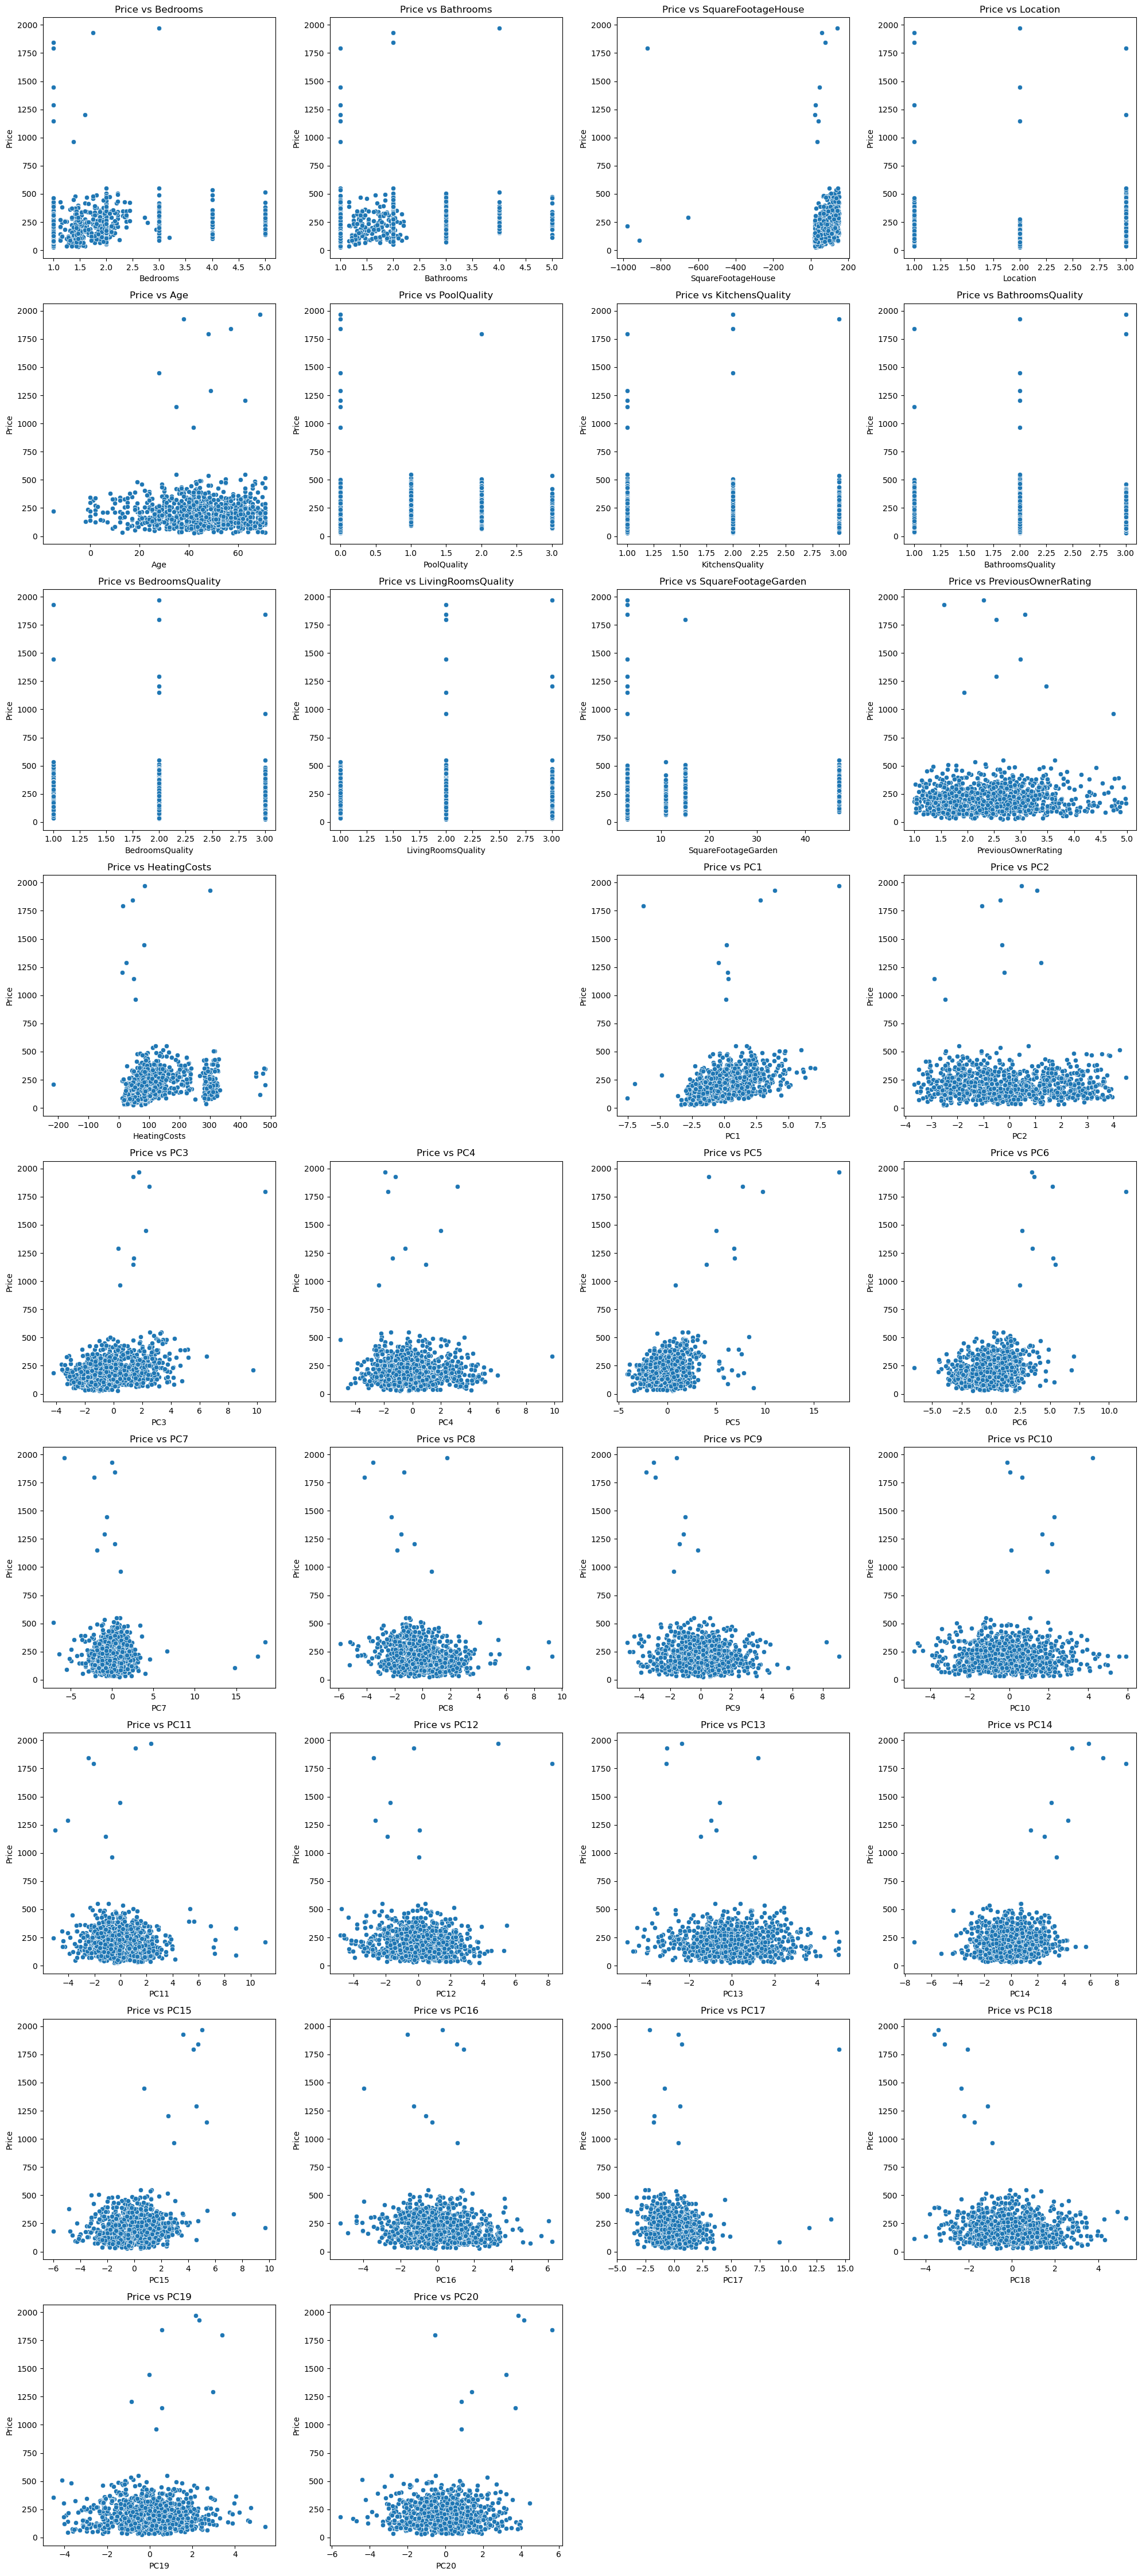

In [29]:
#separating numerical and categorical features
numerical_features = data_with_price.select_dtypes(include=['float64', 'int64']).columns
categorical_features = data_with_price.select_dtypes(include=['bool', 'object']).columns

#combine all features for plotting
all_features = list(numerical_features) + list(categorical_features)
all_features.remove('Price')  # Exclude 'Price' from features

#calculate the number of rows and columns for the subplots
num_features = len(all_features)
num_cols = 4
num_rows = (num_features + num_cols - 1) // num_cols  # Ceiling division

# Set up the matplotlib figure
plt.figure(figsize=(20, num_rows * 5))

# Plot numerical features
for i, col in enumerate(numerical_features):
    if col != 'Price':
        plt.subplot(num_rows, num_cols, i + 1)
        sns.scatterplot(x=data_with_price[col], y=data_with_price['Price'])
        plt.title(f'Price vs {col}')
        plt.xlabel(col)
        plt.ylabel('Price')

# Plot categorical features
for i, col in enumerate(categorical_features):
    plt.subplot(num_rows, num_cols, len(numerical_features) + i)
    sns.boxplot(x=data_with_price[col], y=data_with_price['Price'])
    plt.title(f'Price vs {col}')
    plt.xlabel(col)
    plt.ylabel('Price')

plt.tight_layout()
plt.show()


In [30]:
# Specify columns to drop
columns_to_drop = ['HeatingType', 'DateSinceForSale', 'WindowModelNames']

# Create a new DataFrame 'data_drop_column' without the specified columns
data_drop_column = data.drop(columns=columns_to_drop)

columns_to_replace = ['HasPhotovoltaics', 'HasFiberglass', 'IsFurnished', 'HasFireplace']

# Perform the replacement
data_drop_column[columns_to_replace] = data_drop_column[columns_to_replace].replace({False: 0, True: 1})
data_drop_column[columns_to_replace] = data_drop_column[columns_to_replace].replace({'False': 0, 'True': 1})

# Assuming data and dataTarget are defined
print("Original data shape:", data_drop_column.shape)
print("Original dataTarget shape:", dataTarget.shape)

In [33]:
#step 1: Splitting Data
X_train, X_test, y_train, y_test = train_test_split(data_drop_column, dataTarget, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (796, 17)
X_test shape: (199, 17)
y_train shape: (796,)
y_test shape: (199,)


In [34]:
# Step 2: Initializing and Training the Model
print("\nTraining the RandomForestRegressor model...")

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

print("Model training completed.")


Training the RandomForestRegressor model...
Model training completed.


# Here we have an example with fictional data we created to asses our accurate our model is

In [35]:
# Example: Create X_new for prediction
X_new = pd.DataFrame({
    'Bedrooms': [1.0, 2.0, 2.0, 2.0, 2.0],  # Example values for each feature
    'Bathrooms': [1.0, 1.0, 1.0, 2.0, 1.0],
    'SquareFootageHouse': [35.0, 90.0, 45.0, 62.0, 95.0],
    'Location': [1, 1, 2, 3, 3],
    'Age': [69.0, 38.875, 61.0, 31.0, 48.0],
    'PoolQuality': [0.0, 1.0, 0.0, 0.0, 0.0],
    'HasPhotovoltaics': [1, 0, 0, 0, 0],
    'HasFiberglass': [1, 1, 1, 0, 1],
    'IsFurnished': [0, 0, 1, 1, 1],
    'HasFireplace': [0, 0, 0, 0, 0],
    'KitchensQuality': [2, 3, 2, 2, 3],
    'BathroomsQuality': [2, 1, 3, 1, 2],
    'BedroomsQuality': [1, 2, 2, 2, 2],
    'LivingRoomsQuality': [2, 2, 2, 1, 3],
    'SquareFootageGarden': [3.0, 47.0, 3.0, 3.0, 3.0],
    'PreviousOwnerRating': [3.02, 3.41, 1.62, 3.12, 1.2],
    'HeatingCosts': [80.20625, 147.2, 67.2, 100.8, 95.0]
})


In [36]:
# Make predictions
predictions = model.predict(X_new)

# Print predictions (or use as needed)
print("Predictions:")
print(predictions)


Predictions:
[254.7516819 297.1290972  70.9140355 265.4918623 285.1407126]


# Our Actual Model to predict price is Gradient boosting regression

In [37]:
# One-hot encode categorical columns
data_encoded = pd.get_dummies(data_with_price, drop_first=True)

# Separate features and target variable
X = data_encoded.drop(columns=['Price'])
y = data_encoded['Price']

# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Train the Gradient Boosting model
gbr_model = GradientBoostingRegressor(random_state=42)
gbr_model.fit(X_train, y_train)

GradientBoostingRegressor(random_state=42)

In [38]:
# Evaluate the Random Forest model
y_pred_rf = rf_model.predict(X_test)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("\nRandom Forest Model Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae_rf}")
print(f"Mean Squared Error (MSE): {mse_rf}")
print(f"Root Mean Squared Error (RMSE): {rmse_rf}")
print(f"R-squared (R²): {r2_rf}")

# Evaluate the Gradient Boosting model
y_pred_gbr = gbr_model.predict(X_test)
mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
mse_gbr = mean_squared_error(y_test, y_pred_gbr)
rmse_gbr = np.sqrt(mse_gbr)
r2_gbr = r2_score(y_test, y_pred_gbr)

print("\nGradient Boosting Model Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae_gbr}")
print(f"Mean Squared Error (MSE): {mse_gbr}")
print(f"Root Mean Squared Error (RMSE): {rmse_gbr}")
print(f"R-squared (R²): {r2_gbr}")


Random Forest Model Evaluation Metrics:
Mean Absolute Error (MAE): 45.88259639689118
Mean Squared Error (MSE): 5382.415975643702
Root Mean Squared Error (RMSE): 73.36495059388851
R-squared (R²): 0.6510917539089023

Gradient Boosting Model Evaluation Metrics:
Mean Absolute Error (MAE): 41.74008038673683
Mean Squared Error (MSE): 4658.353591791423
Root Mean Squared Error (RMSE): 68.25213250728085
R-squared (R²): 0.6980281738276962


In [39]:
# Randomly sample new data from the existing dataset
new_data = data_with_price.drop(columns=['Price']).sample(n=5, random_state=42)

# Preprocess the new data similarly to the training data
new_data_encoded = pd.get_dummies(new_data, drop_first=True)

new_data_encoded

,Bedrooms,Bathrooms,SquareFootageHouse,Location,Age,PoolQuality,KitchensQuality,BathroomsQuality,BedroomsQuality,LivingRoomsQuality,...,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
889,1.00000,1.000,38.0,1,42.09375,0.0,3,2,2,2,...,1.422779,-1.734517,-0.094371,-0.183382,1.394615,-0.175399,1.315655,-1.659974,-0.704227,2.055750
468,2.00000,1.875,111.0,2,40.34375,0.0,1,2,1,2,...,0.341056,2.973877,-0.941214,1.587619,0.955834,-2.481770,1.019056,-1.608225,-0.120961,-0.402985
168,1.53125,1.000,75.0,3,24.00000,0.0,2,2,1,1,...,2.492676,-0.010792,0.736975,-2.279079,1.354566,-1.522457,-0.993543,-0.622180,1.520096,1.912829
405,1.00000,1.000,69.0,2,36.00000,1.0,3,1,2,3,...,0.557820,-2.233699,-2.479360,2.874861,0.896308,-0.630319,-1.119551,-3.358872,-1.664319,-1.042255
70,1.00000,1.000,45.0,1,19.00000,0.0,3,3,2,3,...,0.414254,2.288254,-0.116004,0.341881,0.805494,2.276558,3.350527,1.439605,0.315675,-0.744306


In [40]:
# Ensure that all the columns match between the training and new data
missing_cols = set(data_encoded.columns) - set(new_data_encoded.columns)
for col in missing_cols:
    new_data_encoded[col] = 0
new_data_encoded = new_data_encoded[data_encoded.columns.drop('Price')]  # Align the columns

# Standardize the new data
new_data_encoded = scaler.transform(new_data_encoded)  # Ensure the same scaling is applied

# Make predictions on the new data using Gradient Boosting model
new_predictions_gbr = gbr_model.predict(new_data_encoded)

# Print the predictions
print("\nPredictions for New Data using Gradient Boosting:")
print(new_predictions_gbr)

# Make predictions on the new data using Random Forest model
new_predictions_rf = rf_model.predict(new_data_encoded)

# Print the predictions
print("\nPredictions for New Data using Random Forest:")
print(new_predictions_rf)



Predictions for New Data using Gradient Boosting:
[123.52560637 102.16611034 225.73770428 196.27332405 113.00755863]

Predictions for New Data using Random Forest:
[116.576724  135.2233139 250.5462078 143.4035938 155.5609189]


In [41]:
# Make predictions on the new data using Gradient Boosting model
new_predictions_gbr = gbr_model.predict(new_data_encoded)

# Print the predictions
print("\nPredictions for New Data using Gradient Boosting:")
print(new_predictions_gbr)

# Make predictions on the new data using Random Forest model
new_predictions_rf = rf_model.predict(new_data_encoded)

# Print the predictions
print("\nPredictions for New Data using Random Forest:")
print(new_predictions_rf)


Predictions for New Data using Gradient Boosting:
[123.52560637 102.16611034 225.73770428 196.27332405 113.00755863]

Predictions for New Data using Random Forest:
[116.576724  135.2233139 250.5462078 143.4035938 155.5609189]


In [42]:
# Predictions vs Actuals for Gradient Boosting
results_gbr = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_gbr})
print("\nPredictions vs Actuals (Gradient Boosting):")
print(results_gbr.head())



Predictions vs Actuals (Gradient Boosting):
        Actual   Predicted
889  186.11575  123.525606
468  106.85506  102.166110
168  257.74569  225.737704
405  151.29361  196.273324
70   108.73163  113.007559


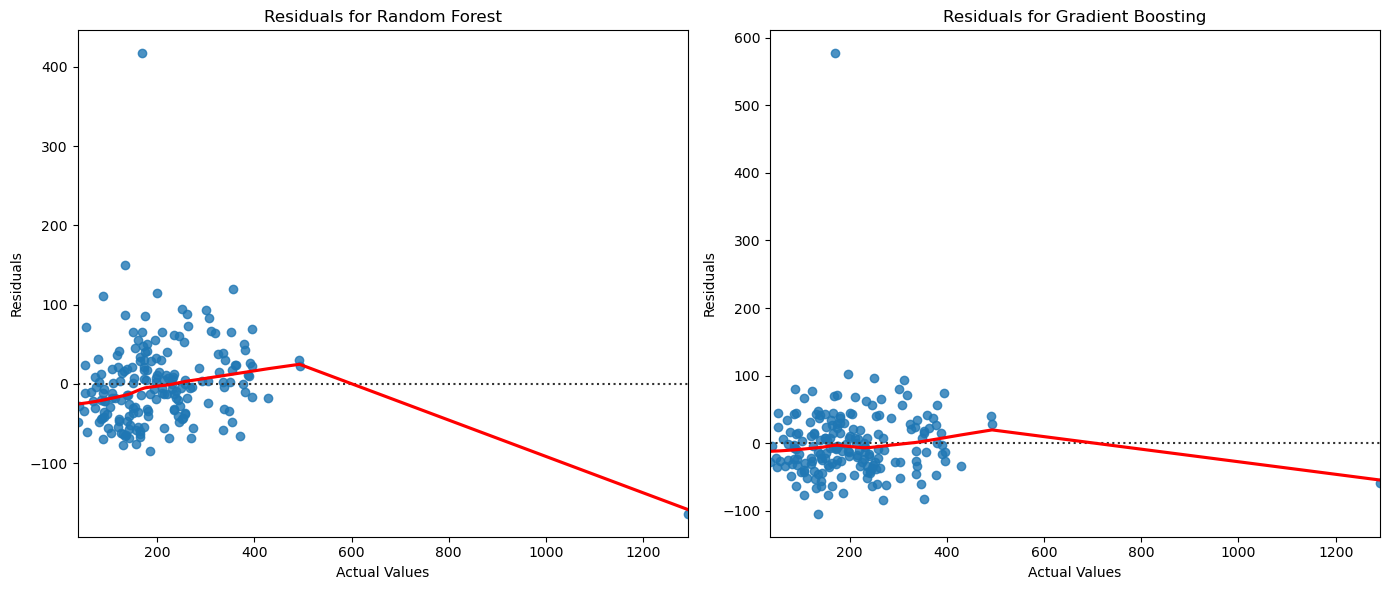

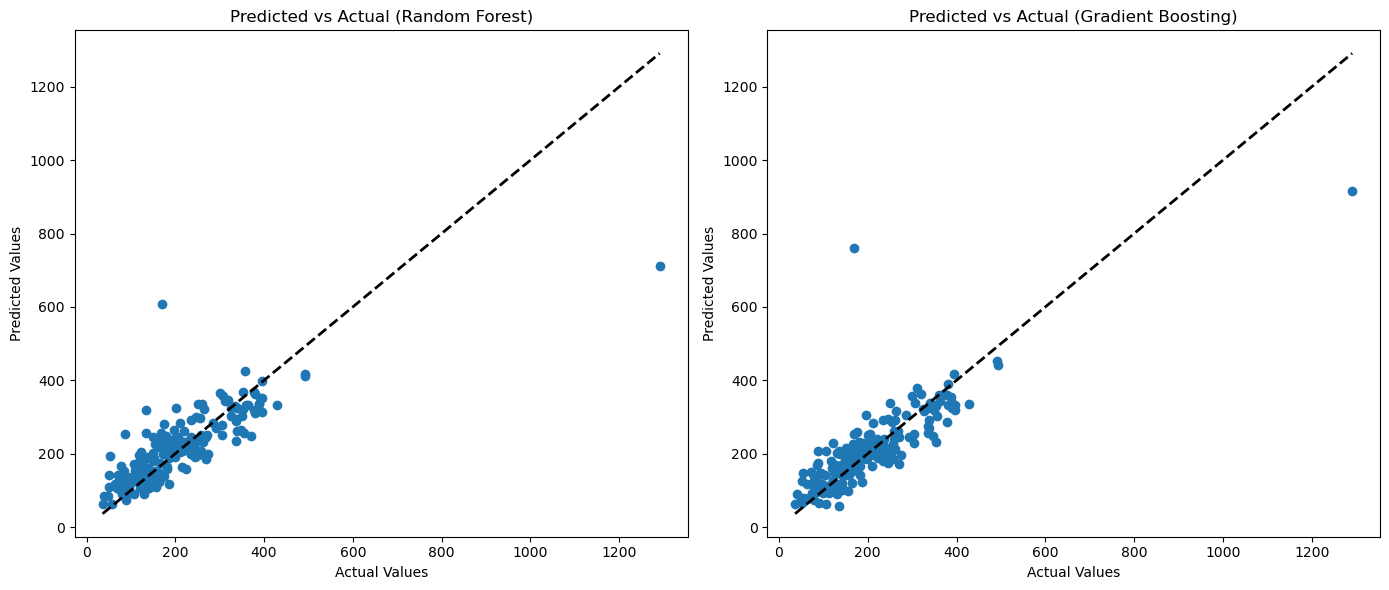

In [43]:
# visualizing the model performances
# Residual plots for both models
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.residplot(x=y_test, y=y_pred_rf, lowess=True, line_kws={'color': 'red'})
plt.title('Residuals for Random Forest')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')

plt.subplot(1, 2, 2)
sns.residplot(x=y_test, y=y_pred_gbr, lowess=True, line_kws={'color': 'red'})
plt.title('Residuals for Gradient Boosting')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()

# Predicted vs Actual plots for both models
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_rf)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('Predicted vs Actual (Random Forest)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_gbr)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('Predicted vs Actual (Gradient Boosting)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

plt.tight_layout()
plt.show()


# Evaluating Model

In [44]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

Missing values in features before imputation:
Bedrooms               0
Bathrooms              0
SquareFootageHouse     0
Location               0
Age                    0
PoolQuality            0
KitchensQuality        0
BathroomsQuality       0
BedroomsQuality        0
LivingRoomsQuality     0
SquareFootageGarden    0
PreviousOwnerRating    0
HeatingCosts           0
Price                  0
LOF                    0
PC1                    0
PC2                    0
PC3                    0
PC4                    0
PC5                    0
PC6                    0
PC7                    0
PC8                    0
PC9                    0
PC10                   0
PC11                   0
PC12                   0
PC13                   0
PC14                   0
PC15                   0
PC16                   0
PC17                   0
PC18                   0
PC19                   0
PC20                   0
dtype: int64
Missing values in features after imputation:
Bedrooms             

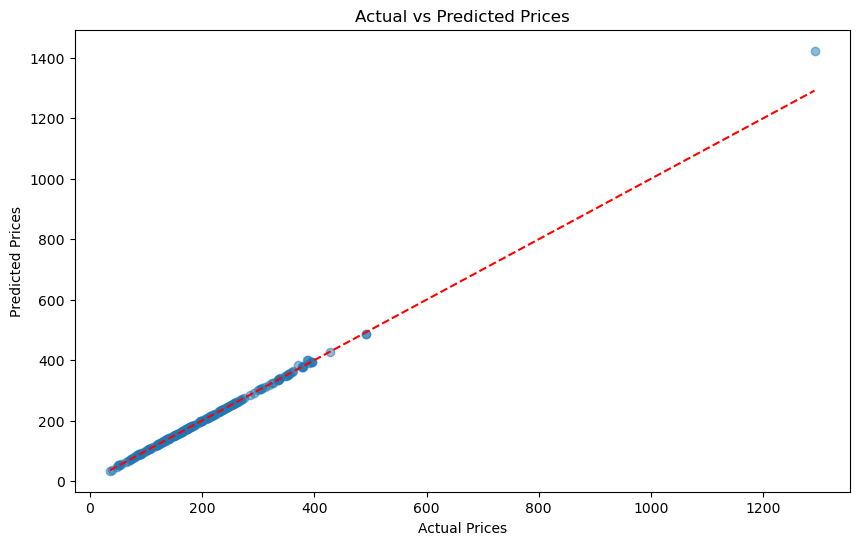

In [45]:
# model evaluation
#make sure no more missing values 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ensure there are no missing values in the target variable
data_with_price = data_with_price.dropna(subset=['Price'])

# Extract the target variable
dataTarget = data_with_price['Price']

# Ensure the features match the cleaned data
data_drop_column = final_data.loc[data_with_price.index]

# Check for missing values in features
print("Missing values in features before imputation:")
print(data_drop_column.isna().sum())

# Impute missing values in features
imputer = SimpleImputer(strategy='mean')
data_drop_column_imputed = pd.DataFrame(imputer.fit_transform(data_drop_column), columns=data_drop_column.columns)

# Verify no missing values in the imputed data
print("Missing values in features after imputation:")
print(data_drop_column_imputed.isna().sum())

# Step 1: Splitting Data
X_train, X_test, y_train, y_test = train_test_split(data_drop_column_imputed, dataTarget, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# Step 2: Initializing and Training the Model
print("\nTraining the RandomForestRegressor model...")

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

print("Model training completed.")

# Step 3: Making Predictions
y_pred = model.predict(X_test)

# Step 4: Calculating Evaluation Metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nModel Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

# Step 5: Optional - Print Predictions vs Actuals
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print("\nPredictions vs Actuals:")
print(results.head())

# Plotting Actual vs Predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices')
plt.show()


# Here are the replies to the Questions Asked

In [47]:
#Q1 If I have a budget of €100,000, what kind of houses will I be able to buy?

In [46]:
data_with_price['Bedrooms'] = data_with_price['Bedrooms'].round()
data_with_price['Bathrooms'] = data_with_price['Bathrooms'].round()

budget = 100.000  # Your budget in euros

# Filter houses within budget
affordable_houses = data_with_price[data_with_price['Price'] <= budget]

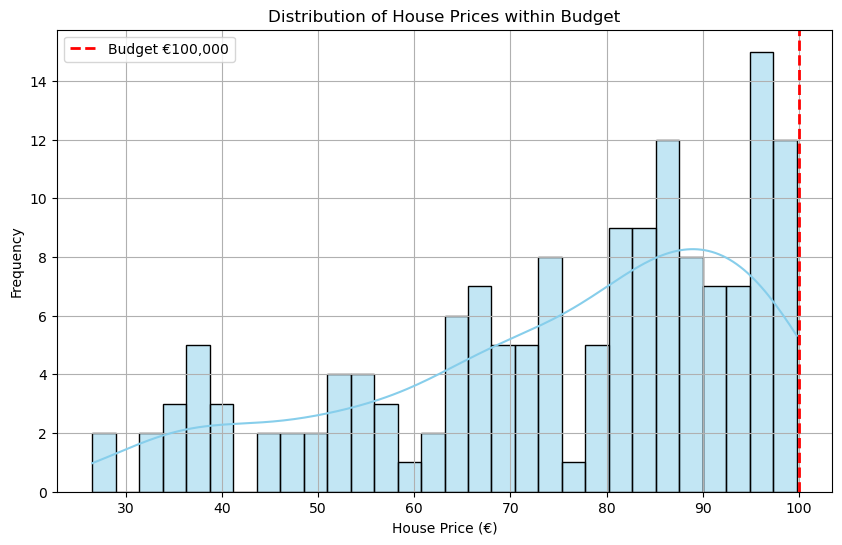

In [47]:
# Distribution plot of house prices within budget
plt.figure(figsize=(10, 6))
sns.histplot(data=affordable_houses, x='Price', bins=30, kde=True, color='skyblue')
plt.axvline(x=budget, color='red', linestyle='--', linewidth=2, label='Budget €100,000')
plt.title('Distribution of House Prices within Budget')
plt.xlabel('House Price (€)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

In [51]:
#if I have a budget of 100k, I wouldn't look at 90-100k
my_budget_house = affordable_houses[affordable_houses['Price'] >= 80.000]

#describe gives us some general information about our df
my_budget_house.describe()


,Bedrooms,Bathrooms,SquareFootageHouse,Location,Age,PoolQuality,KitchensQuality,BathroomsQuality,BedroomsQuality,LivingRoomsQuality,...,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
count,80.00000,80.000000,80.000000,80.0,80.000000,80.000000,80.000000,80.000000,80.000000,80.00000,...,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000
mean,1.36250,1.375000,54.862500,1.85,44.807475,0.875000,1.975000,1.787500,1.987500,1.86250,...,0.382586,0.201228,0.248387,-0.063184,-0.463667,0.409115,0.249577,-0.093801,0.197583,-0.091762
std,0.50925,0.559724,114.277559,0.452839,14.018999,1.151499,0.655551,0.790669,0.737662,0.61095,...,1.523191,1.517749,1.701457,1.312739,1.343281,1.627897,1.597190,1.295573,1.423856,1.439858
min,1.00000,1.000000,-914.000000,1.0,10.000000,0.000000,1.000000,1.000000,1.000000,1.00000,...,-2.783126,-3.194869,-3.345555,-3.352557,-4.392300,-3.149710,-3.234913,-3.323642,-3.113133,-2.889941
25%,1.00000,1.000000,37.250000,2.0,36.820312,0.000000,2.000000,1.000000,1.000000,1.00000,...,-0.564582,-0.788374,-0.831098,-0.966601,-1.273502,-0.557564,-0.697683,-1.148877,-0.949230,-1.034001
50%,1.00000,1.000000,63.500000,2.0,44.921875,0.000000,2.000000,2.000000,2.000000,2.00000,...,0.187705,0.269131,-0.154788,-0.061033,-0.324331,0.121012,0.149124,-0.110185,0.321728,-0.186107
75%,2.00000,2.000000,92.250000,2.0,53.250000,2.000000,2.000000,2.000000,3.000000,2.00000,...,1.049809,1.467580,1.575376,0.604910,0.296828,1.513665,1.051717,0.912327,1.223764,0.853701
max,3.00000,3.000000,144.000000,3.0,70.000000,3.000000,3.000000,3.000000,3.000000,3.00000,...,8.865818,3.750539,4.980596,3.604613,2.428079,6.208482,9.218178,2.295879,5.407842,3.990122


In [52]:
#counting houses with pools
houses_with_pool = my_budget_house[my_budget_house['PoolQuality'] >= 1] # getting total houses with pool for the percentage
total_houses = len(my_budget_house)

# Calculating percentage
percentage_with_pool = (len(houses_with_pool) / total_houses) * 100

print(f"Percentage of houses with a pool: {percentage_with_pool:.2f}%")


Percentage of houses with a pool: 38.75%


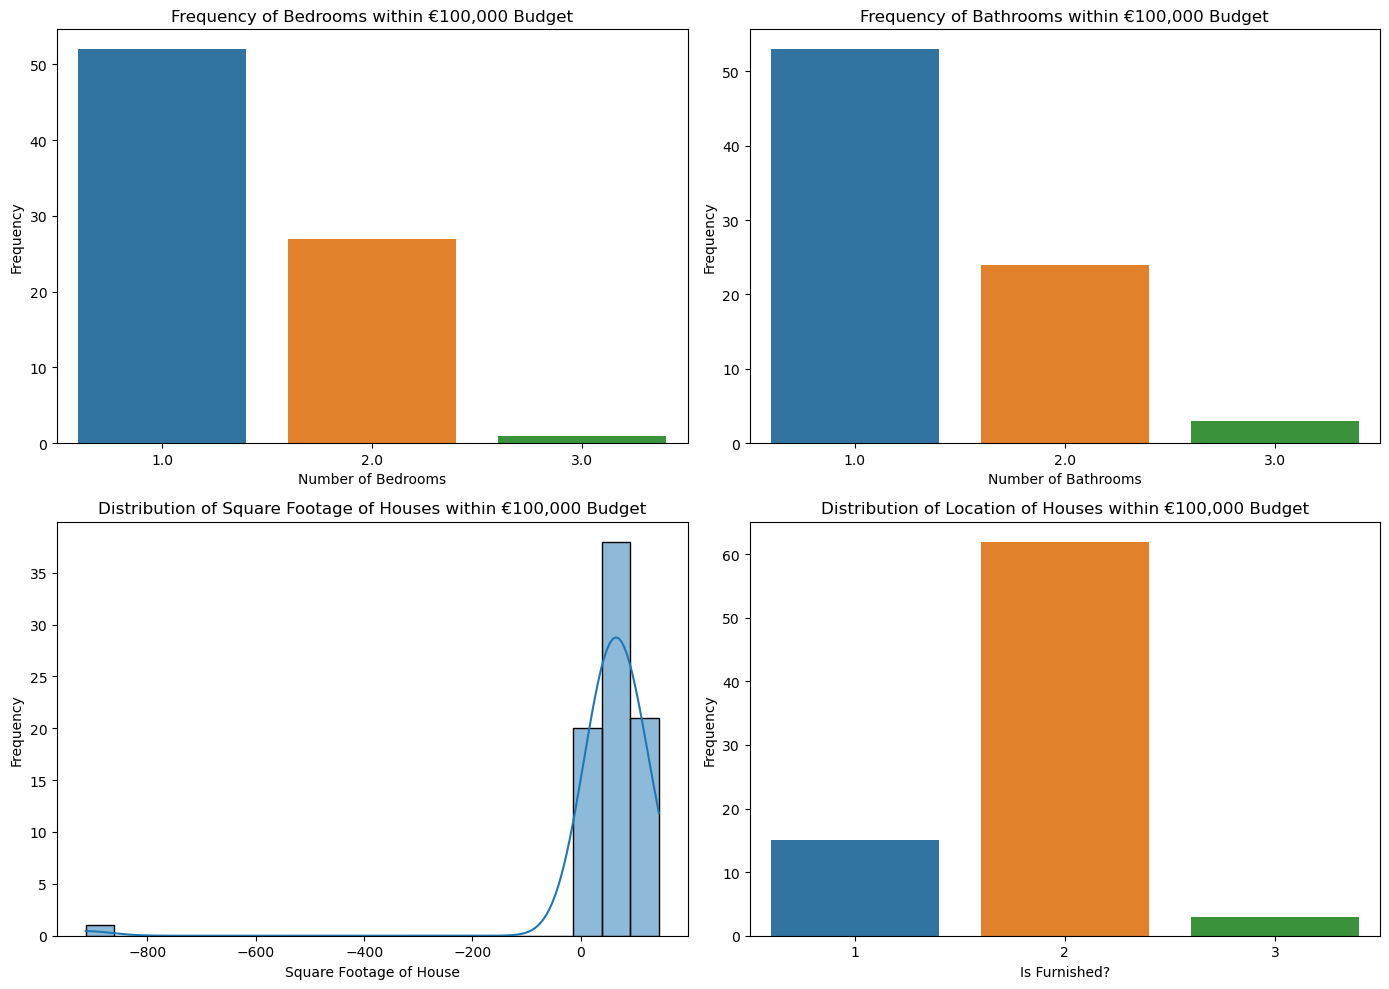

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 10))

# Example: Bedrooms vs Frequency
plt.subplot(2, 2, 1)
sns.countplot(x='Bedrooms', data=my_budget_house)
plt.title('Frequency of Bedrooms within €100,000 Budget')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Frequency')

# Example: Bathrooms vs Frequency
plt.subplot(2, 2, 2)
sns.countplot(x='Bathrooms', data=my_budget_house)
plt.title('Frequency of Bathrooms within €100,000 Budget')
plt.xlabel('Number of Bathrooms')
plt.ylabel('Frequency')

# Example: SquareFootageHouse vs Frequency
plt.subplot(2, 2, 3)
sns.histplot(data=my_budget_house, x='SquareFootageHouse', bins=20, kde=True)
plt.title('Distribution of Square Footage of Houses within €100,000 Budget')
plt.xlabel('Square Footage of House')
plt.ylabel('Frequency')

# Example: Location vs Frequency
plt.subplot(2, 2, 4)
sns.countplot(x='Location', data=my_budget_house)
plt.title('Distribution of Location of Houses within €100,000 Budget')
plt.xlabel('Is Furnished?')
plt.ylabel('Frequency')
#1 urban, 2 suburban, 3 rural


plt.tight_layout()
plt.show()


In [ ]:
#Q2 How much money can I save if I decide not to get a house with a pool?

In [54]:
#calculate average price of houses with pools
avg_price_with_pool = data_with_price[data_with_price['PoolQuality'] >= 1]['Price'].mean()

#calculate average price of houses without pools
avg_price_without_pool = data_with_price[data_with_price['PoolQuality'] == 0]['Price'].mean()

#calculate savings
savings_without_pool = avg_price_with_pool - avg_price_without_pool

print(f"Average price of houses with pools: €{avg_price_with_pool:}")
print(f"Average price of houses without pools: €{avg_price_without_pool:}")
print(f"Savings by not choosing a house with a pool: €{savings_without_pool:}")

Average price of houses with pools: €229.71056528301884
Average price of houses without pools: €209.01637535353535
Savings by not choosing a house with a pool: €20.694189929483485
